<a href="https://colab.research.google.com/github/NehaP92/dsc-capstone-project-v2-onl01-dtsc-pt-041320/blob/master/Capstone_Keras_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf

np.random.seed(0)
tf.random.set_seed(0)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys, glob, shutil
import datetime as dt
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import time
from IPython.display import Image, display
from PIL import Image as Im

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet121, VGG16, Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.regularizers import l2

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

## Functions Used

In [6]:
def unzip(folder_loc,f_name):
  zipped_folder = folder_loc
  fname = f_name
  !cp "{zipped_folder}" .
  !unzip -q "{fname}" 
  !rm "{fname}"

In [7]:
def conv_base(base_model='', weights='imagenet', include_top=False,input_shape=(256, 256, 3), kws={}):

  if base_model == 'VGG16':
    conv_base = VGG16(weights=weights,include_top=include_top,input_shape=input_shape,**kws)
    conv_base.trainable = False
  
  if base_model == 'Xception':
    conv_base = Xception(weights=weights,include_top=include_top,input_shape=input_shape,**kws)
    conv_base.trainable = False
  
  if base_model == 'DenseNet121':
    conv_base = VGG16(weights=weights,include_top=include_top,input_shape=input_shape,**kws)
    conv_base.trainable = False
  
  return conv_base


In [46]:
def transfer_model(conv_base, learning_rate=0.001, dense_layers={},
                   dense_layer_activation='relu', final_layer_activation='softmax',
                   optimizer='Adam', metrics=['acc'], kws={}):
  """"""
  
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())

  for key,value in dense_layers.items():
    model.add(layers.Dense(value, activation=dense_layer_activation,**kws))
  
  model.add(layers.Dense(5, activation=final_layer_activation,**kws))

  if optimizer == 'Adam':
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=metrics)
  
  return model

transfer_model.__doc__+=tf.keras.layers.Dense.__doc__

In [9]:
def transfer_model(conv_base, learning_rate=0.001, dense_layers={},
                   dense_layer_activation='relu', final_layer_activation='softmax',
                   optimizer='Adam', metrics=['acc'],kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                   LeakyReLU=False, LeakyReLU_alpha=0.2, Dropout=False, Dropout_rate=0.2):
  
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())

  for key,value in dense_layers.items():
    model.add(layers.Dense(value, activation=dense_layer_activation))
    if LeakyReLU:
      model.add(layers.LeakyReLU(alpha=LeakyReLU_alpha))
    if Dropout:
      model.add(layers.Dropout(Dropout_rate))
  
  model.add(layers.Dense(5, activation=final_layer_activation))

  if optimizer == 'Adam':
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=metrics)
    
  if optimizer == 'RMSprop':
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=learning_rate),
                  metrics=metrics)
  
  return model

In [10]:
dense_layers={1:4000,2:2000,3:1000}
for key,value in dense_layers.items():
    print(f'model.add(layers.Dense({value}, activation=dense_layer_activation))')

model.add(layers.Dense(4000, activation=dense_layer_activation))
model.add(layers.Dense(2000, activation=dense_layer_activation))
model.add(layers.Dense(1000, activation=dense_layer_activation))


In [11]:
def performance_plot(model, hist, X_test,y_test, metric=['acc']):
  
  hist_df = pd.DataFrame(hist.history)

  if len(metric)>1:
    fig,axes = plt.subplots(ncols=1, nrows = len(metric),figsize=(8,len(metric)*5))
    axes=axes.flatten()
    for i,m in enumerate(metric):
      hist_df[[m,f'val_{m}']].plot(marker='o',ax=axes[i])
      plt.show();
  else:
    axa = hist_df[[metric[0],f'val_{metric[0]}']].plot(marker='o')
    plt.show()
  
  axl = hist_df[['loss','val_loss']].plot(marker='o')
  plt.show();

  y_pred=model.predict(X_test)
  print(metrics.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1)))

  conf_matrix = metrics.confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1),normalize = 'true')
  ax = sns.heatmap(conf_matrix, cmap='Reds', annot=True, square=True)
  ax.set(xlabel='Predicted Class', ylabel='True Class')
  ax.set_ylim(5, 0)
  ax.set(title='Covid: 0 Normal: 1, Pneumonia: 2 TB: 3, TB_Normal: 4')
  plt.show();


In [12]:
# image_set.class_indices

In [13]:
def early_stopping(monitor='val_loss', patience=3,mode='auto',
                   restore_best_weights=False,kws={}):

  par = EarlyStopping(monitor=monitor, patience=patience,mode=mode,
                      restore_best_weights=restore_best_weights, **kws)
  
  return par

In [44]:
def train_model(model, X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val), kws={}):

  hist = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=validation_data, **kws)

In [45]:
def train_model(model, X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val),
                class_weight= class_weights, callbacks=early_stopping()):

  hist = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=validation_data, class_weight= class_weight,
                   callbacks=callbacks)
  return hist

## Data Processing

In [16]:
root_dir = "/content/gdrive/MyDrive/Data Science/Capstone Data"

In [17]:
dir_list = os.listdir(root_dir)


In [18]:
dir_list

['img_labels.csv',
 'Combined',
 'img_labels_colab.csv',
 'Combined_50',
 'Combined_50-20210129T000224Z-001.zip',
 'img_labels_colab_50.csv',
 'Combined-20210130T220345Z-003.zip',
 'Combined-20210130T220345Z-002.zip',
 'Combined-20210130T220345Z-001.zip',
 'img_labels_colab_local.csv']

In [19]:
# zipped_folder = "/content/gdrive/MyDrive/Data Science/Capstone Data/Combined-20210130T220345Z-003.zip"
# fname = 'Combined-20210130T220345Z-003.zip'
# !cp "{zipped_folder}" .
# !unzip -q "{fname}" 
# !rm "{fname}"

In [20]:
unzip("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined-20210130T220345Z-003.zip",'Combined-20210130T220345Z-003.zip')

In [21]:
unzip("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined-20210130T220345Z-002.zip",'Combined-20210130T220345Z-002.zip')

In [22]:
unzip("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined-20210130T220345Z-001.zip",'Combined-20210130T220345Z-001.zip')

In [23]:
len(os.listdir("/content/gdrive/MyDrive/Data Science/Capstone Data/Combined"))

4687

In [24]:
dir_list

['img_labels.csv',
 'Combined',
 'img_labels_colab.csv',
 'Combined_50',
 'Combined_50-20210129T000224Z-001.zip',
 'img_labels_colab_50.csv',
 'Combined-20210130T220345Z-003.zip',
 'Combined-20210130T220345Z-002.zip',
 'Combined-20210130T220345Z-001.zip',
 'img_labels_colab_local.csv']

In [25]:
files=[]
total_img=0
for i in enumerate(dir_list[1:2]):
    folder_loc=os.path.join(root_dir,i[1])
    for j in os.listdir(folder_loc):
        files.append(j)
    total_img+=len(os.listdir(folder_loc))
print(total_img)
print(len(files))

4687
4687


In [26]:
colab_list = os.listdir("/content/Combined")

In [27]:
colab_dir = os.listdir("/content")
colab_dir

['.config', 'gdrive', 'Combined', 'sample_data']

In [28]:
# files=[]
# total_img=0
# for i in enumerate(colab_dir[1:2]):
#     folder_loc=os.path.join(root_dir,i[1])
#     for j in os.listdir(folder_loc):
#         files.append(j)
#     total_img+=len(os.listdir(folder_loc))
# print(total_img)
# print(len(files))

In [29]:
datagen = ImageDataGenerator(rescale = 1./255)

In [30]:
df_img = pd.read_csv('/content/gdrive/MyDrive/Data Science/Capstone Data/img_labels_colab_local.csv',header=None)
df_img.columns = ['file','category']
df_img

,file,category
0,/content/Combined/COVID_0.png,0
1,/content/Combined/COVID_1.png,0
2,/content/Combined/COVID_10.png,0
3,/content/Combined/COVID_100.png,0
4,/content/Combined/COVID_1000.png,0
...,...,...
4682,/content/Combined/Viral Pneumonia_995.png,4
4683,/content/Combined/Viral Pneumonia_996.png,4
4684,/content/Combined/Viral Pneumonia_997.png,4
4685,/content/Combined/Viral Pneumonia_998.png,4


In [31]:
cat_map = {0: 'Covid', 1: 'Normal', 2:'TB', 3:'TB_Normal',4:'Pneumonia'}
df_img['Category_name']=df_img['category'].map(cat_map)
df_img

,file,category,Category_name
0,/content/Combined/COVID_0.png,0,Covid
1,/content/Combined/COVID_1.png,0,Covid
2,/content/Combined/COVID_10.png,0,Covid
3,/content/Combined/COVID_100.png,0,Covid
4,/content/Combined/COVID_1000.png,0,Covid
...,...,...,...
4682,/content/Combined/Viral Pneumonia_995.png,4,Pneumonia
4683,/content/Combined/Viral Pneumonia_996.png,4,Pneumonia
4684,/content/Combined/Viral Pneumonia_997.png,4,Pneumonia
4685,/content/Combined/Viral Pneumonia_998.png,4,Pneumonia


In [32]:
image_set = datagen.flow_from_dataframe(dataframe=df_img,
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 4687 validated image filenames belonging to 5 classes.


In [33]:
# X,y = next(image_set)

## Finding the corrupted image

In [ ]:
image_set_1k = datagen.flow_from_dataframe(dataframe=df_img[0:1000],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 1000 validated image filenames belonging to 1 classes.


In [ ]:
X,y = next(image_set_1k)

In [ ]:
image_set_2k = datagen.flow_from_dataframe(dataframe=df_img[1000:2000],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 1000 validated image filenames belonging to 2 classes.


In [ ]:
X,y = next(image_set_2k)

KeyboardInterrupt: ignored

In [ ]:
image_set_3k = datagen.flow_from_dataframe(dataframe=df_img[2000:3000],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

In [ ]:
X,y = next(image_set_3k)

In [ ]:
image_set_4k = datagen.flow_from_dataframe(dataframe=df_img[3000:4000],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

In [ ]:
X,y = next(image_set_4k)

In [ ]:
image_set_5k = datagen.flow_from_dataframe(dataframe=df_img[4000:],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

In [ ]:
X,y = next(image_set_5k)

In [ ]:
image_set_3k1 = datagen.flow_from_dataframe(dataframe=df_img[2000:2500],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

In [ ]:
X,y = next(image_set_3k1)

In [ ]:
image_set_3k2 = datagen.flow_from_dataframe(dataframe=df_img[2500:2750],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 250 validated image filenames belonging to 2 classes.


In [ ]:
X,y = next(image_set_3k2)

In [ ]:
image_set_3k3 = datagen.flow_from_dataframe(dataframe=df_img[2750:2875],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 125 validated image filenames belonging to 1 classes.


In [ ]:
X,y = next(image_set_3k3)

UnidentifiedImageError: ignored

In [ ]:
image_set_3k4 = datagen.flow_from_dataframe(dataframe=df_img[2875:3000],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 125 validated image filenames belonging to 2 classes.


In [ ]:
X,y = next(image_set_3k4)

In [ ]:
image_set_3k31 = datagen.flow_from_dataframe(dataframe=df_img[2750:2830],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 80 validated image filenames belonging to 1 classes.


In [ ]:
X,y = next(image_set_3k31)

In [ ]:
image_set_3k32 = datagen.flow_from_dataframe(dataframe=df_img[2830:2850],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 20 validated image filenames belonging to 1 classes.


In [ ]:
X,y = next(image_set_3k32)

In [ ]:
image_set_3k33 = datagen.flow_from_dataframe(dataframe=df_img[2850:2865],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 15 validated image filenames belonging to 1 classes.


In [ ]:
X,y = next(image_set_3k33)

In [ ]:
image_set_3k34 = datagen.flow_from_dataframe(dataframe=df_img[2870:2875],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 5 validated image filenames belonging to 1 classes.


In [ ]:
X,y = next(image_set_3k34)

In [ ]:
image_set_3k35 = datagen.flow_from_dataframe(dataframe=df_img[2865:2870],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 5 validated image filenames belonging to 1 classes.


In [ ]:
X,y = next(image_set_3k35)

UnidentifiedImageError: ignored

In [ ]:
df_img[2865:2870]

,file,category,Category_name
2865,/content/Combined/TB_390.png,2,TB
2866,/content/Combined/TB_391.png,2,TB
2867,/content/Combined/TB_392.png,2,TB
2868,/content/Combined/TB_393.png,2,TB
2869,/content/Combined/TB_394.png,2,TB


In [ ]:
for i in range(2865,2870):
  image_set_3k35 = datagen.flow_from_dataframe(dataframe=df_img[i:(i+1)],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )
  try:
    X,y = next(image_set_3k35)
  except:
    print(f'error: row {i}')

Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
Found 1 validated image filenames belonging to 1 classes.
error: row 2869


In [ ]:
image_set_3k36 = datagen.flow_from_dataframe(dataframe=df_img[2869:2870],
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )
X,y = next(image_set_3k36)

Found 1 validated image filenames belonging to 1 classes.


UnidentifiedImageError: ignored

In [ ]:
df_img[2869:2870]

,file,category,Category_name
2869,/content/Combined/TB_394.png,2,TB


## Remove row 2870

In [34]:
df_img_updated = df_img.copy().drop(index=2869)
df_img_updated

,file,category,Category_name
0,/content/Combined/COVID_0.png,0,Covid
1,/content/Combined/COVID_1.png,0,Covid
2,/content/Combined/COVID_10.png,0,Covid
3,/content/Combined/COVID_100.png,0,Covid
4,/content/Combined/COVID_1000.png,0,Covid
...,...,...,...
4682,/content/Combined/Viral Pneumonia_995.png,4,Pneumonia
4683,/content/Combined/Viral Pneumonia_996.png,4,Pneumonia
4684,/content/Combined/Viral Pneumonia_997.png,4,Pneumonia
4685,/content/Combined/Viral Pneumonia_998.png,4,Pneumonia


In [35]:
image_set = datagen.flow_from_dataframe(dataframe=df_img_updated,
                                        directory='/',
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 4686 validated image filenames belonging to 5 classes.


In [36]:
X,y = next(image_set)

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size = 0.1,random_state = 7)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train,test_size = 0.1,random_state = 7)

In [38]:
X_test.shape

(469, 256, 256, 3)

In [39]:
X_test.shape[1:]

(256, 256, 3)

TB : 2


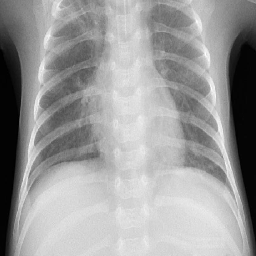

In [40]:
i=np.random.choice(range(len(X)))
if y[i][0] == 1:
  print ("COVID : 0")
if y[i][1] == 1:
  print ("Normal : 1")
if y[i][2] == 1:
  print ("TB : 2")
if y[i][3] == 1:
  print ("TB_Normal : 3")
if y[i][4] == 1:
  print ("Viral Pneumonia : 4")
display(array_to_img(X[i]))

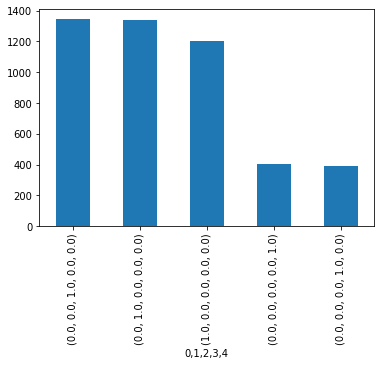

In [41]:
pd.DataFrame(y).value_counts().plot(kind="bar")

In [42]:
classes = [0,1,2,3,4]

In [43]:
class_weights = class_weight.compute_class_weight('balanced', classes, y_train.argmax(axis=1))
class_weights = dict(zip(classes,class_weights))
class_weights

{0: 0.7947643979057591,
 1: 0.69,
 2: 0.6937842778793418,
 3: 2.4483870967741934,
 4: 2.2589285714285716}

## Dummy

In [ ]:
dummy = DummyClassifier()
dummy.fit(X_train,y_train)
y_pred=dummy.predict(X_val)
print(metrics.classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.32      0.31      0.31       104
           1       0.32      0.31      0.31       130
           2       0.31      0.30      0.30       119
           3       0.06      0.07      0.07        30
           4       0.06      0.05      0.06        39

   micro avg       0.28      0.27      0.27       422
   macro avg       0.21      0.21      0.21       422
weighted avg       0.27      0.27      0.27       422
 samples avg       0.19      0.27      0.21       422



/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
score = balanced_accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print (score)
# metrics.plot_confusion_matrix(dummy, X_train, y_train, normalize='true')

0.21982331394096102


In [ ]:
metrics.confusion_matrix(y_val.argmax(axis=1),y_pred.argmax(axis=1),normalize = 'true')

array([[0.61538462, 0.22115385, 0.14423077, 0.01923077, 0.        ],
       [0.62307692, 0.21538462, 0.1       , 0.03076923, 0.03076923],
       [0.52941176, 0.23529412, 0.20168067, 0.01680672, 0.01680672],
       [0.36666667, 0.43333333, 0.1       , 0.06666667, 0.03333333],
       [0.56410256, 0.25641026, 0.12820513, 0.05128205, 0.        ]])

## Model 1: Using VGG16

In [ ]:
# IMAGE_SIZE = (150, 150)
# NUM_CLASSES = 5
# BATCH_SIZE = 10 # try reducing batch size or freeze more layers if your GPU runs out of memory
# NUM_EPOCHS = 20
LEARNING_RATE =0.001 

In [ ]:
conv_base_vgg16 = conv_base('VGG16')

In [ ]:
model_vgg16 = transfer_model(conv_base=conv_base_vgg16,learning_rate=0.001,dense_layers={1:256},kernel_regularizer=None, bias_regularizer=None)

In [ ]:
hist_vgg16 = model_vgg16.fit(X_train,y_train,epochs=20,batch_size=100,validation_data=(X_val,y_val))

Epoch 1/20
38/38 [==============================] - 38s 696ms/step - loss: 2.3084 - acc: 0.6005 - val_loss: 0.2477 - val_acc: 0.9123
Epoch 2/20
38/38 [==============================] - 22s 591ms/step - loss: 0.1944 - acc: 0.9348 - val_loss: 0.1451 - val_acc: 0.9573
Epoch 3/20
38/38 [==============================] - 23s 598ms/step - loss: 0.1291 - acc: 0.9541 - val_loss: 0.1134 - val_acc: 0.9597
Epoch 4/20
38/38 [==============================] - 23s 598ms/step - loss: 0.0833 - acc: 0.9766 - val_loss: 0.1239 - val_acc: 0.9550
Epoch 5/20
38/38 [==============================] - 23s 598ms/step - loss: 0.0761 - acc: 0.9756 - val_loss: 0.1294 - val_acc: 0.9455
Epoch 6/20
38/38 [==============================] - 23s 598ms/step - loss: 0.0583 - acc: 0.9826 - val_loss: 0.1108 - val_acc: 0.9573
Epoch 7/20
38/38 [==============================] - 23s 598ms/step - loss: 0.0453 - acc: 0.9881 - val_loss: 0.1218 - val_acc: 0.9550
Epoch 8/20
38/38 [==============================] - 23s 599ms/step - 

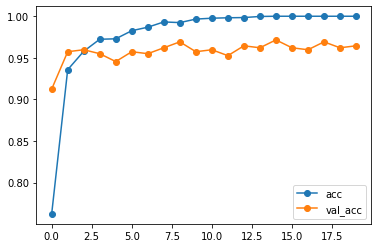

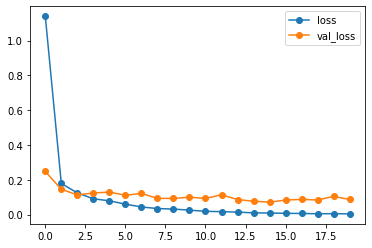

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       134
           1       0.96      0.99      0.97       132
           2       0.99      0.95      0.97       126
           3       0.88      0.84      0.86        45
           4       0.82      0.84      0.83        32

    accuracy                           0.96       469
   macro avg       0.93      0.93      0.93       469
weighted avg       0.96      0.96      0.96       469



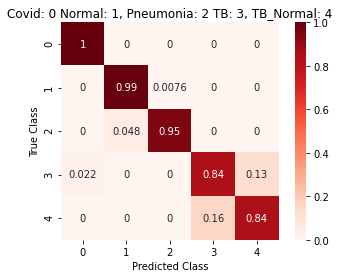

In [ ]:
performance_plot(model=model_vgg16, hist=hist_vgg16, X_test=X_test,y_test=y_test,metric=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 23,104,837
Trainable params: 8,390,149
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_vgg16_2=transfer_model(conv_base=conv_base_vgg16,dense_layers={1:256})

In [ ]:
hist_vgg16_2 = train_model(model_vgg16_2,X_train,y_train,epochs=20, batch_size=100,class_weight=None, callbacks=None)

Epoch 1/20
38/38 [==============================] - 22s 559ms/step - loss: 3.4018 - acc: 0.5396 - val_loss: 0.2627 - val_acc: 0.9123
Epoch 2/20
38/38 [==============================] - 21s 566ms/step - loss: 0.2237 - acc: 0.9219 - val_loss: 0.1401 - val_acc: 0.9502
Epoch 3/20
38/38 [==============================] - 22s 571ms/step - loss: 0.1330 - acc: 0.9561 - val_loss: 0.1202 - val_acc: 0.9573
Epoch 4/20
38/38 [==============================] - 22s 573ms/step - loss: 0.0796 - acc: 0.9748 - val_loss: 0.1013 - val_acc: 0.9668
Epoch 5/20
38/38 [==============================] - 22s 577ms/step - loss: 0.1011 - acc: 0.9578 - val_loss: 0.0853 - val_acc: 0.9787
Epoch 6/20
38/38 [==============================] - 22s 584ms/step - loss: 0.0639 - acc: 0.9778 - val_loss: 0.1398 - val_acc: 0.9455
Epoch 7/20
38/38 [==============================] - 22s 588ms/step - loss: 0.0454 - acc: 0.9880 - val_loss: 0.1739 - val_acc: 0.9313
Epoch 8/20
38/38 [==============================] - 22s 592ms/step - 

In [ ]:
performance_plot(model_vgg16_2,hist=hist_vgg16_2, X_test=X_test,y_test=y_test)

AttributeError: ignored

In [ ]:
model2 = models.Sequential()
model2.add(conv_base_vgg16)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.Dense(5, activation='sigmoid',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics=['acc'])

In [ ]:
hist = model2.fit(X_train,y_train,epochs=20,batch_size=100,validation_data=(X_val,y_val))

Epoch 1/20
38/38 [==============================] - 23s 599ms/step - loss: 6.4494 - acc: 0.5359 - val_loss: 1.4809 - val_acc: 0.8957
Epoch 2/20
38/38 [==============================] - 23s 602ms/step - loss: 1.2364 - acc: 0.9208 - val_loss: 0.8082 - val_acc: 0.9550
Epoch 3/20
38/38 [==============================] - 23s 599ms/step - loss: 0.7476 - acc: 0.9438 - val_loss: 0.6159 - val_acc: 0.9336
Epoch 4/20
38/38 [==============================] - 23s 594ms/step - loss: 0.5668 - acc: 0.9501 - val_loss: 0.5738 - val_acc: 0.8957
Epoch 5/20
38/38 [==============================] - 22s 594ms/step - loss: 0.4554 - acc: 0.9549 - val_loss: 0.3999 - val_acc: 0.9573
Epoch 6/20
38/38 [==============================] - 23s 599ms/step - loss: 0.3927 - acc: 0.9569 - val_loss: 0.4689 - val_acc: 0.9123
Epoch 7/20
38/38 [==============================] - 23s 599ms/step - loss: 0.3691 - acc: 0.9529 - val_loss: 0.3502 - val_acc: 0.9502
Epoch 8/20
38/38 [==============================] - 23s 600ms/step - 

In [ ]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 1285      
Total params: 23,104,837
Trainable params: 8,390,149
Non-trainable params: 14,714,688
_________________________________________________________________


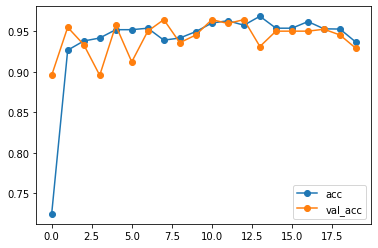

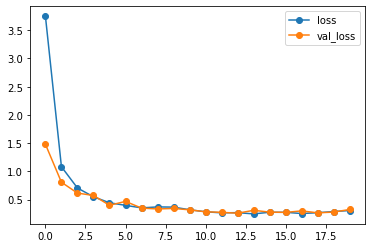

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       134
           1       0.98      0.84      0.91       132
           2       0.88      0.98      0.93       126
           3       0.78      0.87      0.82        45
           4       0.77      0.75      0.76        32

    accuracy                           0.92       469
   macro avg       0.88      0.89      0.88       469
weighted avg       0.92      0.92      0.92       469



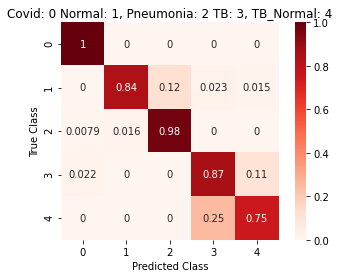

In [ ]:
performance_plot(model2,hist, X_test=X_test,y_test=y_test)

## With Early Stopping

In [ ]:
model_vgg16_3 = transfer_model(conv_base_vgg16,dense_layers={1:256})

In [ ]:
hist_vgg16_3=train_model(model_vgg16_3,X_train,y_train, class_weight=None)

Epoch 1/50
60/60 [==============================] - 20s 327ms/step - loss: 2.8627 - acc: 0.5958 - val_loss: 0.2903 - val_acc: 0.8886
Epoch 2/50
60/60 [==============================] - 20s 332ms/step - loss: 0.1879 - acc: 0.9316 - val_loss: 0.1507 - val_acc: 0.9479
Epoch 3/50
60/60 [==============================] - 20s 338ms/step - loss: 0.1266 - acc: 0.9571 - val_loss: 0.1588 - val_acc: 0.9479
Epoch 4/50
60/60 [==============================] - 21s 351ms/step - loss: 0.0898 - acc: 0.9725 - val_loss: 0.1414 - val_acc: 0.9502
Epoch 5/50
60/60 [==============================] - 21s 358ms/step - loss: 0.0617 - acc: 0.9831 - val_loss: 0.1112 - val_acc: 0.9692
Epoch 6/50
60/60 [==============================] - 21s 351ms/step - loss: 0.0488 - acc: 0.9897 - val_loss: 0.1246 - val_acc: 0.9526
Epoch 7/50
60/60 [==============================] - 21s 348ms/step - loss: 0.0386 - acc: 0.9911 - val_loss: 0.1078 - val_acc: 0.9621
Epoch 8/50
60/60 [==============================] - 21s 351ms/step - 

In [ ]:
model_vgg16_3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 1285      
Total params: 23,104,837
Trainable params: 8,390,149
Non-trainable params: 14,714,688
_________________________________________________________________


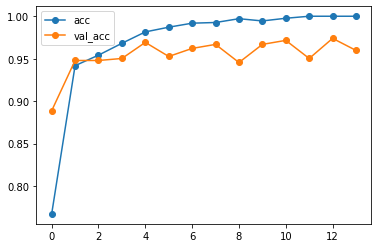

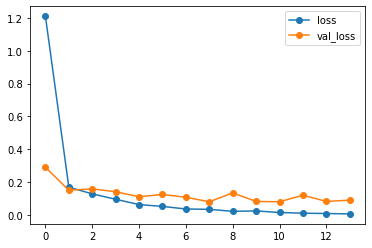

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       134
           1       0.96      0.96      0.96       132
           2       0.98      0.96      0.97       126
           3       0.90      0.78      0.83        45
           4       0.72      0.88      0.79        32

    accuracy                           0.95       469
   macro avg       0.91      0.92      0.91       469
weighted avg       0.95      0.95      0.95       469



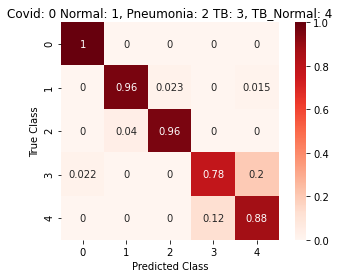

In [ ]:
performance_plot(model = model_vgg16_3,hist=hist_vgg16_3, X_test=X_test,y_test=y_test)

In [ ]:
model_vgg16_4 = transfer_model(conv_base_vgg16,dense_layers={1:256})

In [ ]:
hist_vgg16_4 = train_model(model_vgg16_4,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 21s 334ms/step - loss: 2.5121 - acc: 0.6510 - val_loss: 0.8016 - val_acc: 0.7488
Epoch 2/50
60/60 [==============================] - 20s 341ms/step - loss: 0.4576 - acc: 0.8825 - val_loss: 0.1658 - val_acc: 0.9408
Epoch 3/50
60/60 [==============================] - 21s 350ms/step - loss: 0.1447 - acc: 0.9634 - val_loss: 0.1452 - val_acc: 0.9526
Epoch 4/50
60/60 [==============================] - 21s 359ms/step - loss: 0.1198 - acc: 0.9713 - val_loss: 0.0975 - val_acc: 0.9668
Epoch 5/50
60/60 [==============================] - 21s 353ms/step - loss: 0.0716 - acc: 0.9847 - val_loss: 0.1050 - val_acc: 0.9597
Epoch 6/50
60/60 [==============================] - 21s 351ms/step - loss: 0.0589 - acc: 0.9892 - val_loss: 0.0969 - val_acc: 0.9573
Epoch 7/50
60/60 [==============================] - 21s 351ms/step - loss: 0.0407 - acc: 0.9948 - val_loss: 0.1547 - val_acc: 0.9479
Epoch 8/50
60/60 [==============================] - 21s 353ms/step - 

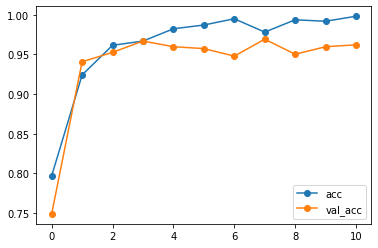

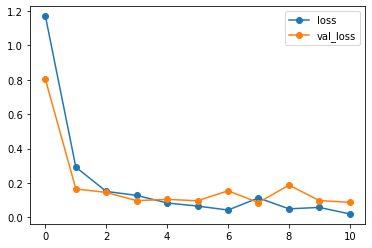

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       134
           1       0.95      0.96      0.96       132
           2       0.98      0.95      0.96       126
           3       0.88      0.82      0.85        45
           4       0.75      0.84      0.79        32

    accuracy                           0.95       469
   macro avg       0.91      0.92      0.91       469
weighted avg       0.95      0.95      0.95       469



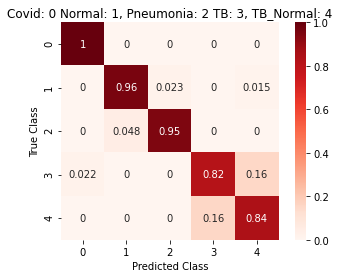

In [ ]:
performance_plot(model = model_vgg16_4,hist=hist_vgg16_4, X_test=X_test,y_test=y_test)

In [ ]:
model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.Dense(5, activation='softmax',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=0.001),
 metrics=['acc'])

In [ ]:
hist3 = model3.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_loss', patience=3,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50
60/60 [==============================] - 22s 360ms/step - loss: 4.7603 - acc: 0.6393 - val_loss: 0.9135 - val_acc: 0.9242
Epoch 2/50
60/60 [==============================] - 19s 318ms/step - loss: 0.7914 - acc: 0.9367 - val_loss: 0.7252 - val_acc: 0.8649
Epoch 3/50
60/60 [==============================] - 19s 324ms/step - loss: 0.5574 - acc: 0.9321 - val_loss: 0.4544 - val_acc: 0.9360
Epoch 4/50
60/60 [==============================] - 20s 331ms/step - loss: 0.4102 - acc: 0.9498 - val_loss: 0.4336 - val_acc: 0.9289
Epoch 5/50
60/60 [==============================] - 20s 340ms/step - loss: 0.3750 - acc: 0.9472 - val_loss: 0.3549 - val_acc: 0.9360
Epoch 6/50
60/60 [==============================] - 21s 343ms/step - loss: 0.3151 - acc: 0.9564 - val_loss: 0.3464 - val_acc: 0.9360
Epoch 7/50
60/60 [==============================] - 21s 352ms/step - loss: 0.3646 - acc: 0.9409 - val_loss: 0.3774 - val_acc: 0.9242
Epoch 8/50
60/60 [==============================] - 22s 359ms/step - 

In [ ]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1285      
Total params: 23,104,837
Trainable params: 8,390,149
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
hist_df3 = pd.DataFrame(hist3.history)
hist_df3

,loss,acc,val_loss,val_acc
0,2.539153,0.808432,0.913536,0.924171
1,0.734781,0.927009,0.725243,0.864929
2,0.509153,0.936759,0.454360,0.936019
3,0.427680,0.936759,0.433610,0.928910
4,0.361803,0.951515,0.354912,0.936019
5,0.332158,0.948090,0.346407,0.936019
6,0.341425,0.946245,0.377430,0.924171
7,0.318349,0.943347,0.319407,0.926540
8,0.317629,0.944137,0.327600,0.924171
9,0.305981,0.947299,0.294366,0.947867


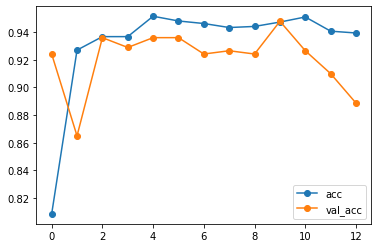

In [ ]:
hist_df3[['acc','val_acc']].plot(marker='o')

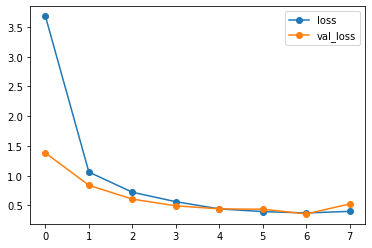

In [ ]:
hist_df3[['loss','val_loss']].plot(marker='o')

In [ ]:
classes = [0,1,2,3,4]

In [ ]:
class_weights = class_weight.compute_class_weight('balanced', classes, y_train.argmax(axis=1))

In [ ]:
class_weights = dict(zip(classes,class_weights))
class_weights

{0: 0.7947643979057591,
 1: 0.69,
 2: 0.6937842778793418,
 3: 2.4483870967741934,
 4: 2.2589285714285716}

In [ ]:
model3 = models.Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.Dense(5, activation='softmax',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=0.001),
 metrics=['acc'])

In [ ]:
hist3 = model3.fit(X_train,y_train,epochs=50,batch_size=64,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_loss', patience=3,mode='auto',
                                        restore_best_weights=False),class_weight=class_weights)

Epoch 1/50
60/60 [==============================] - 20s 319ms/step - loss: 5.3106 - acc: 0.5772 - val_loss: 1.3910 - val_acc: 0.8791
Epoch 2/50
60/60 [==============================] - 19s 323ms/step - loss: 1.1284 - acc: 0.9090 - val_loss: 0.7318 - val_acc: 0.9171
Epoch 3/50
60/60 [==============================] - 20s 329ms/step - loss: 0.6829 - acc: 0.9378 - val_loss: 0.5054 - val_acc: 0.9431
Epoch 4/50
60/60 [==============================] - 20s 338ms/step - loss: 0.4789 - acc: 0.9598 - val_loss: 0.6273 - val_acc: 0.8697
Epoch 5/50
60/60 [==============================] - 21s 345ms/step - loss: 0.5113 - acc: 0.9286 - val_loss: 0.4357 - val_acc: 0.9336
Epoch 6/50
60/60 [==============================] - 21s 351ms/step - loss: 0.4264 - acc: 0.9516 - val_loss: 0.3713 - val_acc: 0.9479
Epoch 7/50
60/60 [==============================] - 21s 359ms/step - loss: 0.4424 - acc: 0.9406 - val_loss: 0.3725 - val_acc: 0.9431
Epoch 8/50
60/60 [==============================] - 22s 367ms/step - 

In [ ]:
hist_df3 = pd.DataFrame(hist3.history)
hist_df3

,loss,acc,val_loss,val_acc
0,3.075293,0.771278,1.391029,0.879147
1,0.961542,0.913043,0.731759,0.917062
2,0.621868,0.944137,0.505423,0.943128
3,0.489379,0.948090,0.627296,0.869668
4,0.487347,0.933860,0.435690,0.933649
5,0.411708,0.955204,0.371308,0.947867
6,0.439132,0.942819,0.372517,0.943128
7,0.466847,0.935705,0.393523,0.940758
8,0.443352,0.947036,0.460745,0.890995


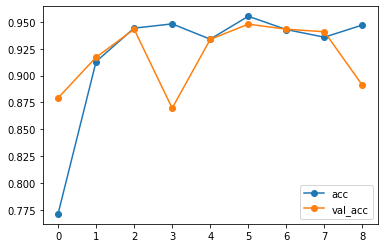

In [ ]:
hist_df3[['acc','val_acc']].plot(marker='o')

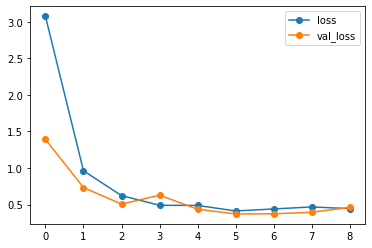

In [ ]:
hist_df3[['loss','val_loss']].plot(marker='o')

In [ ]:
y_pred=model3.predict(X_test)
print(metrics.classification_report(y_test.argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       127
           1       1.00      0.81      0.90       132
           2       0.78      0.99      0.88       128
           3       0.73      0.93      0.81        40
           4       0.91      0.69      0.78        42

    accuracy                           0.89       469
   macro avg       0.88      0.87      0.86       469
weighted avg       0.91      0.89      0.89       469



## Modifications

In [ ]:
model_m1 = transfer_model(conv_base_vgg16,dense_layers={1:4000,2:2000,3:1000,4:500,5:256},optimizer='RMSprop')

In [ ]:
hist_m1 = train_model(model_m1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 24s 386ms/step - loss: 28.1062 - acc: 0.3019 - val_loss: 1.5105 - val_acc: 0.5687
Epoch 2/50
60/60 [==============================] - 23s 389ms/step - loss: 0.7511 - acc: 0.7258 - val_loss: 0.8316 - val_acc: 0.7749
Epoch 3/50
60/60 [==============================] - 24s 394ms/step - loss: 0.8614 - acc: 0.8014 - val_loss: 1.1661 - val_acc: 0.6517
Epoch 4/50
60/60 [==============================] - 24s 395ms/step - loss: 0.4479 - acc: 0.8701 - val_loss: 0.6523 - val_acc: 0.7796
Epoch 5/50
60/60 [==============================] - 24s 400ms/step - loss: 0.3663 - acc: 0.9024 - val_loss: 0.2185 - val_acc: 0.9218
Epoch 6/50
60/60 [==============================] - 24s 404ms/step - loss: 0.3442 - acc: 0.9218 - val_loss: 0.1702 - val_acc: 0.9408
Epoch 7/50
60/60 [==============================] - 24s 408ms/step - loss: 0.2672 - acc: 0.9356 - val_loss: 0.3613 - val_acc: 0.8981
Epoch 8/50
60/60 [==============================] - 24s 409ms/step -

In [ ]:
model_m1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 4000)              131076000 
_________________________________________________________________
dense_25 (Dense)             (None, 2000)              8002000   
_________________________________________________________________
dense_26 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_27 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_28 (Dense)             (None, 256)             

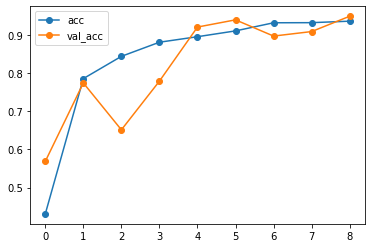

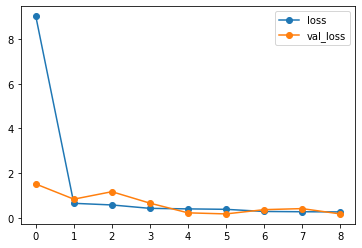

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       134
           1       0.97      0.87      0.92       132
           2       0.90      0.96      0.93       126
           3       0.92      0.73      0.81        45
           4       0.69      0.91      0.78        32

    accuracy                           0.92       469
   macro avg       0.89      0.89      0.89       469
weighted avg       0.93      0.92      0.92       469



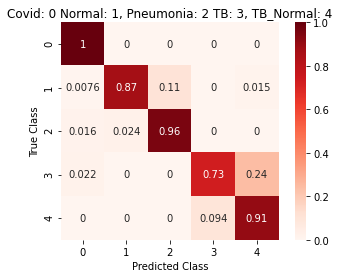

In [ ]:
performance_plot(model_m1, hist_m1,X_test,y_test)

In [ ]:
model_m2 = transfer_model(conv_base_vgg16,dense_layers={1:3000,2:1500,3:500,4:256},Dropout=True)

In [ ]:
hist_m2 = train_model(model_m2,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 33s 388ms/step - loss: 3.8387 - acc: 0.4261 - val_loss: 0.2783 - val_acc: 0.8863
Epoch 2/50
60/60 [==============================] - 21s 345ms/step - loss: 0.4276 - acc: 0.8761 - val_loss: 0.2162 - val_acc: 0.9147
Epoch 3/50
60/60 [==============================] - 21s 353ms/step - loss: 0.3282 - acc: 0.9145 - val_loss: 0.2004 - val_acc: 0.9360
Epoch 4/50
60/60 [==============================] - 21s 358ms/step - loss: 0.2610 - acc: 0.9267 - val_loss: 0.2020 - val_acc: 0.9289
Epoch 5/50
60/60 [==============================] - 22s 367ms/step - loss: 0.2755 - acc: 0.9249 - val_loss: 0.1748 - val_acc: 0.9289
Epoch 6/50
60/60 [==============================] - 22s 374ms/step - loss: 0.1800 - acc: 0.9534 - val_loss: 0.1698 - val_acc: 0.9455
Epoch 7/50
60/60 [==============================] - 22s 373ms/step - loss: 0.1619 - acc: 0.9576 - val_loss: 0.1990 - val_acc: 0.9408
Epoch 8/50
60/60 [==============================] - 22s 369ms/step - 

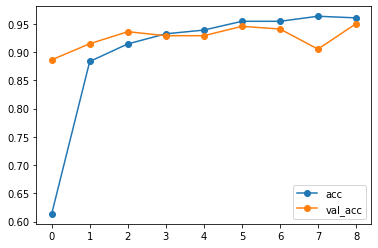

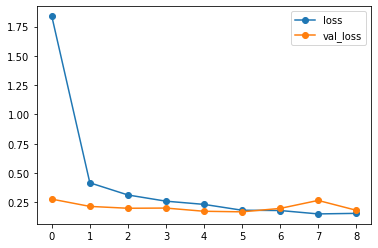

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       130
           1       0.98      0.97      0.97       133
           2       0.98      0.98      0.98       134
           3       0.86      0.53      0.66        36
           4       0.60      0.92      0.73        36

    accuracy                           0.93       469
   macro avg       0.88      0.87      0.86       469
weighted avg       0.95      0.93      0.93       469



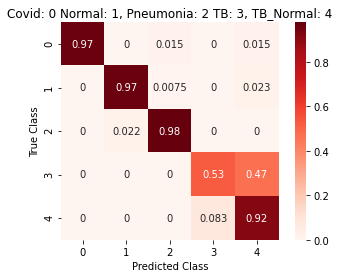

In [ ]:
performance_plot(model_m2,hist_m2,X_test,y_test)

In [ ]:
model_m3 = transfer_model(conv_base_vgg16,dense_layers={1:3000,2:1500,3:500,4:256},optimizer='RMSprop',LeakyReLU=True,Dropout=True)

In [ ]:
hist_m3 = train_model(model_m3,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 24s 381ms/step - loss: 19.6719 - acc: 0.3659 - val_loss: 0.8280 - val_acc: 0.7251
Epoch 2/50
60/60 [==============================] - 23s 388ms/step - loss: 0.7753 - acc: 0.7594 - val_loss: 0.7650 - val_acc: 0.7654
Epoch 3/50
60/60 [==============================] - 24s 396ms/step - loss: 0.6510 - acc: 0.8261 - val_loss: 0.2141 - val_acc: 0.9336
Epoch 4/50
60/60 [==============================] - 24s 396ms/step - loss: 0.3896 - acc: 0.8931 - val_loss: 0.3037 - val_acc: 0.8981
Epoch 5/50
60/60 [==============================] - 23s 392ms/step - loss: 0.3933 - acc: 0.8967 - val_loss: 0.4208 - val_acc: 0.8483
Epoch 6/50
60/60 [==============================] - 23s 392ms/step - loss: 0.3244 - acc: 0.9144 - val_loss: 2.0107 - val_acc: 0.6943


In [ ]:
model_m4 = transfer_model(conv_base_vgg16,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True,Dropout=True)

In [ ]:
hist_m4 = train_model(model_m4,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 23s 375ms/step - loss: 3.6350 - acc: 0.4279 - val_loss: 0.2982 - val_acc: 0.9052
Epoch 2/50
60/60 [==============================] - 23s 382ms/step - loss: 0.4222 - acc: 0.8742 - val_loss: 0.2241 - val_acc: 0.9242
Epoch 3/50
60/60 [==============================] - 22s 371ms/step - loss: 0.3311 - acc: 0.9081 - val_loss: 0.1669 - val_acc: 0.9431
Epoch 4/50
60/60 [==============================] - 22s 367ms/step - loss: 0.2531 - acc: 0.9343 - val_loss: 0.2271 - val_acc: 0.9171
Epoch 5/50
60/60 [==============================] - 22s 370ms/step - loss: 0.2362 - acc: 0.9337 - val_loss: 0.1289 - val_acc: 0.9550
Epoch 6/50
60/60 [==============================] - 22s 374ms/step - loss: 0.2084 - acc: 0.9430 - val_loss: 0.2221 - val_acc: 0.9218
Epoch 7/50
60/60 [==============================] - 22s 373ms/step - loss: 0.2037 - acc: 0.9503 - val_loss: 0.1224 - val_acc: 0.9526
Epoch 8/50
60/60 [==============================] - 22s 369ms/step - 

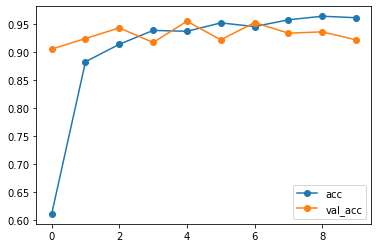

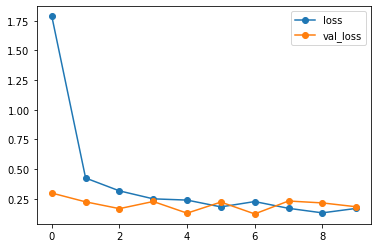

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       130
           1       1.00      0.95      0.97       133
           2       0.95      0.99      0.97       134
           3       0.65      0.92      0.76        36
           4       0.84      0.58      0.69        36

    accuracy                           0.94       469
   macro avg       0.89      0.88      0.87       469
weighted avg       0.94      0.94      0.94       469



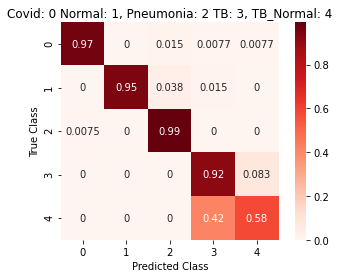

In [ ]:
performance_plot(model_m4,hist_m4,X_test,y_test)

## LeakyRelu

In [ ]:
model4 = models.Sequential()
model4.add(conv_base)
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model4.add(layers.LeakyReLU(alpha=0.2))
model4.add(layers.Dense(5, activation='sigmoid',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model4.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=LEARNING_RATE),
 metrics=['acc'])

In [ ]:
hist4 = model4.fit(X_train,y_train,epochs=50,batch_size=100,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=0,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50
38/38 [==============================] - 21s 535ms/step - loss: 6.2759 - acc: 0.5995 - val_loss: 1.3344 - val_acc: 0.9171
Epoch 2/50
38/38 [==============================] - 20s 540ms/step - loss: 1.1387 - acc: 0.9360 - val_loss: 0.8205 - val_acc: 0.9265
Epoch 3/50
38/38 [==============================] - 21s 547ms/step - loss: 0.7308 - acc: 0.9413 - val_loss: 0.5888 - val_acc: 0.9289
Epoch 4/50
38/38 [==============================] - 21s 559ms/step - loss: 0.5545 - acc: 0.9445 - val_loss: 0.4780 - val_acc: 0.9384
Epoch 5/50
38/38 [==============================] - 21s 561ms/step - loss: 0.4470 - acc: 0.9540 - val_loss: 0.4546 - val_acc: 0.9218
Epoch 6/50
38/38 [==============================] - 21s 566ms/step - loss: 0.4087 - acc: 0.9483 - val_loss: 0.4208 - val_acc: 0.9171
Epoch 7/50
38/38 [==============================] - 22s 573ms/step - loss: 0.3607 - acc: 0.9548 - val_loss: 0.3550 - val_acc: 0.9384
Epoch 8/50
38/38 [==============================] - 22s 572ms/step - 

In [ ]:
model4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 23,104,837
Trainable params: 8,390,149
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
hist_df4 = pd.DataFrame(hist3.history)
hist_df4

,loss,acc,val_loss,val_acc
0,3.680338,0.734914,1.383044,0.912322
1,1.061711,0.936759,0.839746,0.931280
2,0.722768,0.942556,0.607120,0.945498
3,0.563561,0.942819,0.494458,0.947867
4,0.442614,0.954414,0.442944,0.943128
5,0.397382,0.956785,0.437074,0.931280
6,0.374398,0.949671,0.358426,0.952607
7,0.401351,0.931752,0.526302,0.888626


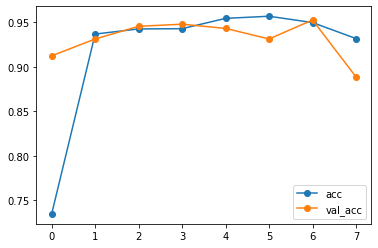

In [ ]:
hist_df4[['acc','val_acc']].plot(marker='o')

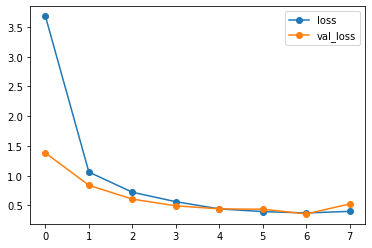

In [ ]:
hist_df4[['loss','val_loss']].plot(marker='o')

In [ ]:
model_vgg16_LR = transfer_model(conv_base_vgg16,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True)

In [ ]:
model_vgg16_LR.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 3000)              98307000  
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3000)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1500)              4501500   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1500)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)              

In [ ]:
hist_vgg16_LR = train_model(model_vgg16_LR,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 22s 351ms/step - loss: 5.7993 - acc: 0.3683 - val_loss: 0.4076 - val_acc: 0.8412
Epoch 2/50
60/60 [==============================] - 21s 355ms/step - loss: 0.3169 - acc: 0.9139 - val_loss: 0.2411 - val_acc: 0.9052
Epoch 3/50
60/60 [==============================] - 22s 361ms/step - loss: 0.2448 - acc: 0.9370 - val_loss: 0.1441 - val_acc: 0.9336
Epoch 4/50
60/60 [==============================] - 22s 370ms/step - loss: 0.1445 - acc: 0.9651 - val_loss: 0.1817 - val_acc: 0.9242
Epoch 5/50
60/60 [==============================] - 23s 376ms/step - loss: 0.1146 - acc: 0.9712 - val_loss: 0.1417 - val_acc: 0.9455
Epoch 6/50
60/60 [==============================] - 22s 372ms/step - loss: 0.0953 - acc: 0.9822 - val_loss: 0.1357 - val_acc: 0.9502
Epoch 7/50
60/60 [==============================] - 22s 370ms/step - loss: 0.0792 - acc: 0.9812 - val_loss: 0.2199 - val_acc: 0.9218
Epoch 8/50
60/60 [==============================] - 22s 372ms/step - 

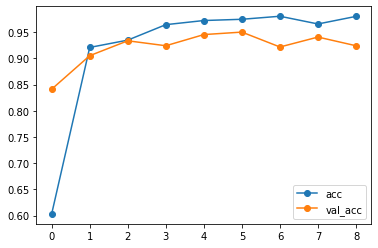

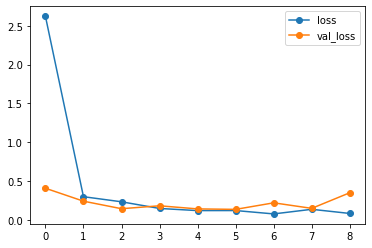

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       127
           1       0.98      0.99      0.99       132
           2       0.98      0.98      0.98       128
           3       0.97      0.80      0.88        40
           4       0.83      0.95      0.89        42

    accuracy                           0.97       469
   macro avg       0.95      0.94      0.94       469
weighted avg       0.97      0.97      0.97       469



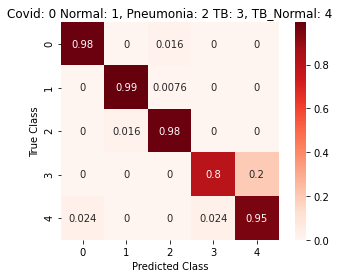

In [ ]:
performance_plot(model_vgg16_LR,hist_vgg16_LR,X_test,y_test)

## Xception

In [ ]:
conv_base = Xception(weights='imagenet',include_top=False,input_shape=(256, 256, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=LEARNING_RATE),
 metrics=['acc'])

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
hist = model.fit(X_train,y_train,epochs=50,batch_size=100,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_acc', min_delta=0, patience=0,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50
38/38 [==============================] - 27s 606ms/step - loss: 12.3835 - acc: 0.6274 - val_loss: 0.9206 - val_acc: 0.8768
Epoch 2/50
38/38 [==============================] - 21s 547ms/step - loss: 0.5793 - acc: 0.9169 - val_loss: 0.2787 - val_acc: 0.9171
Epoch 3/50
38/38 [==============================] - 21s 558ms/step - loss: 0.1708 - acc: 0.9489 - val_loss: 0.2895 - val_acc: 0.9076


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_9 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               33554688  
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 1285      
Total params: 54,417,453
Trainable params: 33,555,973
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
hist_df = pd.DataFrame(hist3.history)
hist_df

,loss,acc,val_loss,val_acc
0,3.680338,0.734914,1.383044,0.912322
1,1.061711,0.936759,0.839746,0.931280
2,0.722768,0.942556,0.607120,0.945498
3,0.563561,0.942819,0.494458,0.947867
4,0.442614,0.954414,0.442944,0.943128
5,0.397382,0.956785,0.437074,0.931280
6,0.374398,0.949671,0.358426,0.952607
7,0.401351,0.931752,0.526302,0.888626


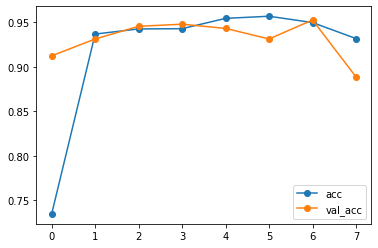

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

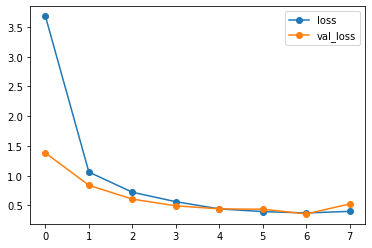

In [ ]:
hist_df[['loss','val_loss']].plot(marker='o')

In [ ]:
conv_base_xception = conv_base(base_model='Xception')

In [ ]:
model_xception_1 = transfer_model(conv_base_xception,dense_layers={1:4000,2:2000,3:1000,4:500,5:256},optimizer='RMSprop')

In [ ]:
hist_xception_1 = train_model(model_xception_1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 47s 619ms/step - loss: 199.9343 - acc: 0.4638 - val_loss: 2.3649 - val_acc: 0.3815
Epoch 2/50
60/60 [==============================] - 36s 594ms/step - loss: 1.2136 - acc: 0.6857 - val_loss: 0.6154 - val_acc: 0.7607
Epoch 3/50
60/60 [==============================] - 37s 610ms/step - loss: 0.7247 - acc: 0.8229 - val_loss: 0.4336 - val_acc: 0.8531
Epoch 4/50
60/60 [==============================] - 37s 611ms/step - loss: 0.5039 - acc: 0.8728 - val_loss: 0.3867 - val_acc: 0.8389
Epoch 5/50
60/60 [==============================] - 37s 611ms/step - loss: 0.3757 - acc: 0.9084 - val_loss: 0.5469 - val_acc: 0.8934
Epoch 6/50
60/60 [==============================] - 37s 611ms/step - loss: 0.4462 - acc: 0.9104 - val_loss: 0.4456 - val_acc: 0.9005
Epoch 7/50
60/60 [==============================] - 37s 612ms/step - loss: 0.2791 - acc: 0.9352 - val_loss: 0.4630 - val_acc: 0.8531


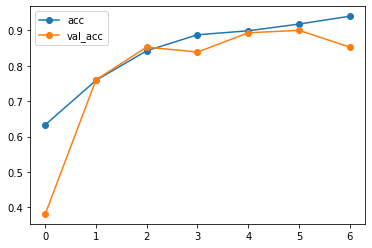

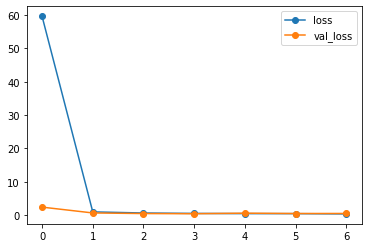

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       127
           1       0.86      1.00      0.93       132
           2       0.97      0.86      0.91       128
           3       1.00      0.17      0.30        40
           4       0.54      1.00      0.70        42

    accuracy                           0.87       469
   macro avg       0.87      0.79      0.76       469
weighted avg       0.91      0.87      0.86       469



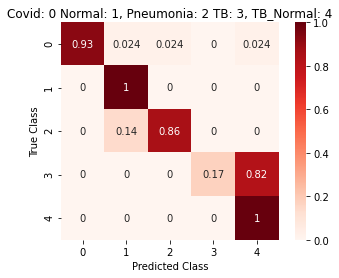

In [ ]:
performance_plot(model_xception_1,hist_xception_1,X_test=X_test,y_test=y_test)

In [ ]:
model_xception_LR = transfer_model(conv_base_xception,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True)

In [ ]:
model_xception_LR.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 3000)              393219000 
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 3000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1500)              4501500   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1500)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 500)              

In [ ]:
hist_xception_LR = train_model(model_xception_LR,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 34s 506ms/step - loss: 26.0762 - acc: 0.5111 - val_loss: 0.3012 - val_acc: 0.8863
Epoch 2/50
60/60 [==============================] - 28s 470ms/step - loss: 0.3591 - acc: 0.8951 - val_loss: 0.2412 - val_acc: 0.9242
Epoch 3/50
60/60 [==============================] - 28s 462ms/step - loss: 0.2762 - acc: 0.9238 - val_loss: 0.2819 - val_acc: 0.9005
Epoch 4/50
60/60 [==============================] - 28s 465ms/step - loss: 0.2011 - acc: 0.9506 - val_loss: 0.2712 - val_acc: 0.9147
Epoch 5/50
60/60 [==============================] - 28s 466ms/step - loss: 0.1199 - acc: 0.9711 - val_loss: 0.2173 - val_acc: 0.9242
Epoch 6/50
60/60 [==============================] - 28s 464ms/step - loss: 0.1004 - acc: 0.9706 - val_loss: 0.3105 - val_acc: 0.9147
Epoch 7/50
60/60 [==============================] - 28s 463ms/step - loss: 0.1252 - acc: 0.9719 - val_loss: 0.3591 - val_acc: 0.8981
Epoch 8/50
60/60 [==============================] - 28s 463ms/step -

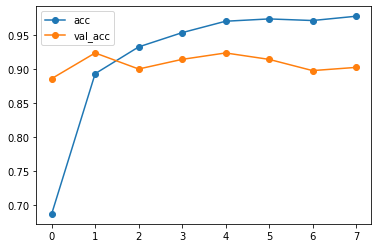

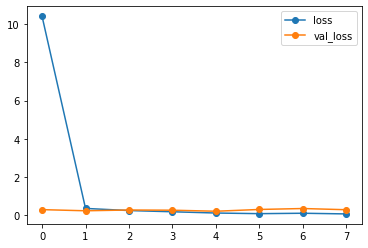

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       130
           1       0.95      0.97      0.96       133
           2       0.95      0.97      0.96       134
           3       0.60      0.86      0.70        36
           4       0.82      0.50      0.62        36

    accuracy                           0.91       469
   macro avg       0.86      0.85      0.84       469
weighted avg       0.92      0.91      0.91       469



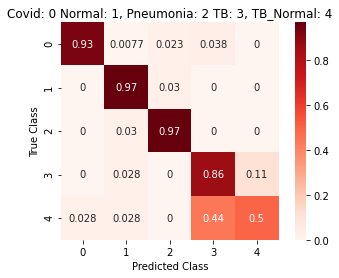

In [ ]:
performance_plot(model_xception_LR,hist_xception_LR,X_test,y_test)

In [ ]:
model_xception_m1= transfer_model(conv_base_xception,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True,Dropout=True)

In [ ]:
hist_xception_m1 = train_model(model_xception_m1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 38s 466ms/step - loss: 17.0417 - acc: 0.4801 - val_loss: 0.4654 - val_acc: 0.8531
Epoch 2/50
60/60 [==============================] - 26s 441ms/step - loss: 0.5975 - acc: 0.8497 - val_loss: 0.3214 - val_acc: 0.8697
Epoch 3/50
60/60 [==============================] - 27s 451ms/step - loss: 0.4360 - acc: 0.8793 - val_loss: 0.2291 - val_acc: 0.9052
Epoch 4/50
60/60 [==============================] - 28s 462ms/step - loss: 0.3816 - acc: 0.9103 - val_loss: 0.3266 - val_acc: 0.8910
Epoch 5/50
60/60 [==============================] - 28s 467ms/step - loss: 0.3608 - acc: 0.9070 - val_loss: 0.2304 - val_acc: 0.9076
Epoch 6/50
60/60 [==============================] - 28s 469ms/step - loss: 0.3463 - acc: 0.9106 - val_loss: 0.2152 - val_acc: 0.9218
Epoch 7/50
60/60 [==============================] - 28s 463ms/step - loss: 0.2524 - acc: 0.9396 - val_loss: 0.2181 - val_acc: 0.9265
Epoch 8/50
60/60 [==============================] - 28s 466ms/step -

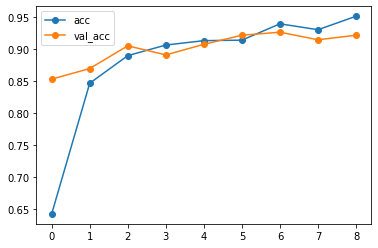

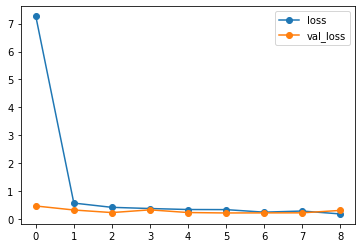

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       127
           1       0.94      0.98      0.96       132
           2       0.97      0.92      0.94       128
           3       0.85      0.88      0.86        40
           4       0.90      0.90      0.90        42

    accuracy                           0.95       469
   macro avg       0.93      0.93      0.93       469
weighted avg       0.95      0.95      0.95       469



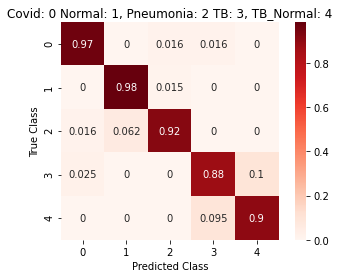

In [ ]:
performance_plot(model_xception_m1,hist_xception_m1,X_test,y_test)

In [ ]:
model_xception_m2= transfer_model(conv_base_xception,dense_layers={1:3000,2:1500,3:500,4:256},
                                  optimizer='RMSprop',LeakyReLU=True,Dropout=True)

In [ ]:
hist_xception_m2 = train_model(model_xception_m2,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 35s 544ms/step - loss: 97.1016 - acc: 0.4742 - val_loss: 0.4772 - val_acc: 0.8199
Epoch 2/50
60/60 [==============================] - 31s 525ms/step - loss: 1.0597 - acc: 0.7723 - val_loss: 1.6219 - val_acc: 0.7773
Epoch 3/50
60/60 [==============================] - 32s 534ms/step - loss: 0.9112 - acc: 0.8090 - val_loss: 0.3072 - val_acc: 0.8649
Epoch 4/50
60/60 [==============================] - 33s 546ms/step - loss: 0.5046 - acc: 0.8804 - val_loss: 0.8077 - val_acc: 0.7749
Epoch 5/50
60/60 [==============================] - 33s 550ms/step - loss: 0.4513 - acc: 0.8917 - val_loss: 0.2673 - val_acc: 0.9076
Epoch 6/50
60/60 [==============================] - 33s 546ms/step - loss: 0.3609 - acc: 0.9114 - val_loss: 0.2162 - val_acc: 0.9289
Epoch 7/50
60/60 [==============================] - 33s 546ms/step - loss: 0.3342 - acc: 0.9141 - val_loss: 0.2949 - val_acc: 0.8673
Epoch 8/50
60/60 [==============================] - 33s 547ms/step -

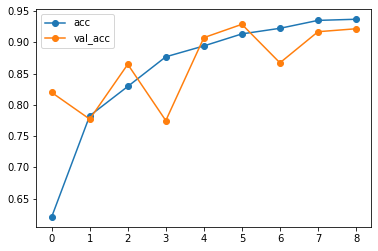

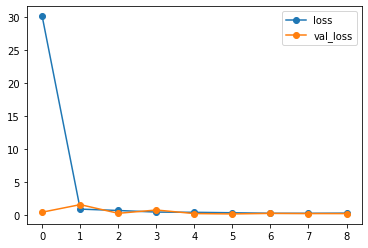

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       127
           1       0.98      0.90      0.94       132
           2       0.89      0.97      0.93       128
           3       0.85      0.88      0.86        40
           4       0.88      0.90      0.89        42

    accuracy                           0.94       469
   macro avg       0.92      0.92      0.92       469
weighted avg       0.94      0.94      0.94       469



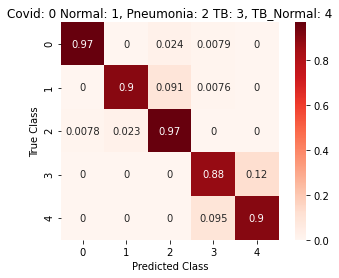

In [ ]:
performance_plot(model_xception_m2,hist_xception_m2,X_test,y_test)

## DensNet121

In [ ]:
conv_base = DenseNet121(weights='imagenet',include_top=False,input_shape=(256, 256, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=0.001),
 metrics=['acc'])

In [ ]:
hist = model.fit(X_train,y_train,epochs=50,batch_size=100,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_acc', min_delta=0, patience=0,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50
38/38 [==============================] - 25s 491ms/step - loss: 11.8027 - acc: 0.6497 - val_loss: 0.4131 - val_acc: 0.9218
Epoch 2/50
38/38 [==============================] - 15s 385ms/step - loss: 0.2758 - acc: 0.9491 - val_loss: 0.3473 - val_acc: 0.9289
Epoch 3/50
38/38 [==============================] - 15s 387ms/step - loss: 0.1223 - acc: 0.9663 - val_loss: 0.3558 - val_acc: 0.9336
Epoch 4/50
38/38 [==============================] - 15s 391ms/step - loss: 0.0547 - acc: 0.9823 - val_loss: 0.2269 - val_acc: 0.9550
Epoch 5/50
38/38 [==============================] - 15s 394ms/step - loss: 0.0262 - acc: 0.9920 - val_loss: 0.3044 - val_acc: 0.9455


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten_10 (Flatten)         (None, 65536)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               16777472  
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 1285      
Total params: 23,816,261
Trainable params: 16,778,757
Non-trainable params: 7,037,504
_________________________________________________________________


In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,acc,val_loss,val_acc
0,3.680338,0.734914,1.383044,0.912322
1,1.061711,0.936759,0.839746,0.931280
2,0.722768,0.942556,0.607120,0.945498
3,0.563561,0.942819,0.494458,0.947867
4,0.442614,0.954414,0.442944,0.943128
5,0.397382,0.956785,0.437074,0.931280
6,0.374398,0.949671,0.358426,0.952607
7,0.401351,0.931752,0.526302,0.888626


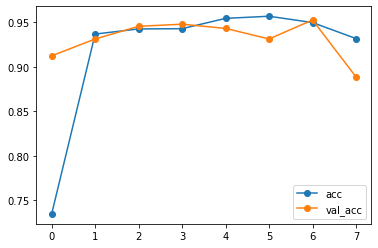

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

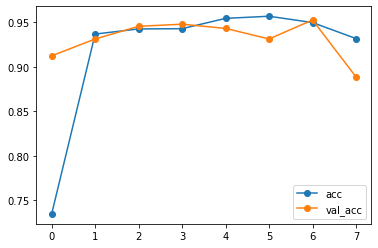

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

In [ ]:
conv_base_dnet = conv_base(base_model='DenseNet121')

In [ ]:
model_dnet_1 = transfer_model(conv_base_dnet,dense_layers={1:4000,2:2000,3:1000,4:500,5:256},optimizer='RMSprop')

In [ ]:
hist_dnet_1 = train_model(model_dnet_1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 29s 438ms/step - loss: 22.0491 - acc: 0.2809 - val_loss: 0.4511 - val_acc: 0.8033
Epoch 2/50
60/60 [==============================] - 24s 399ms/step - loss: 0.8429 - acc: 0.6835 - val_loss: 1.9324 - val_acc: 0.4550
Epoch 3/50
60/60 [==============================] - 24s 406ms/step - loss: 0.6581 - acc: 0.7865 - val_loss: 0.2524 - val_acc: 0.9100
Epoch 4/50
60/60 [==============================] - 25s 420ms/step - loss: 0.4491 - acc: 0.8866 - val_loss: 0.2809 - val_acc: 0.8720
Epoch 5/50
60/60 [==============================] - 25s 410ms/step - loss: 0.3026 - acc: 0.9131 - val_loss: 0.1903 - val_acc: 0.9289
Epoch 6/50
60/60 [==============================] - 24s 409ms/step - loss: 0.3372 - acc: 0.9222 - val_loss: 0.2999 - val_acc: 0.8555
Epoch 7/50
60/60 [==============================] - 25s 410ms/step - loss: 0.3435 - acc: 0.9154 - val_loss: 0.1819 - val_acc: 0.9218
Epoch 8/50
60/60 [==============================] - 25s 412ms/step -

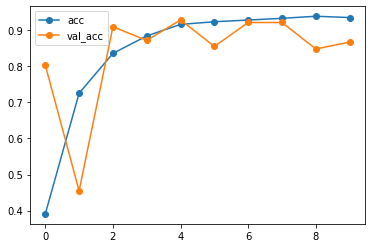

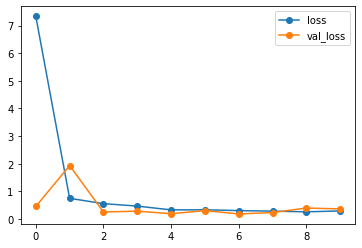

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       127
           1       1.00      0.73      0.85       132
           2       0.77      0.98      0.86       128
           3       0.97      0.70      0.81        40
           4       0.67      0.98      0.80        42

    accuracy                           0.87       469
   macro avg       0.88      0.86      0.85       469
weighted avg       0.90      0.87      0.87       469



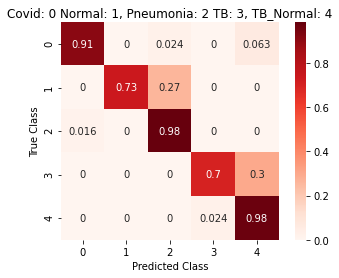

In [ ]:
performance_plot(model_dnet_1,hist_dnet_1,X_test,y_test)

In [ ]:
model_dnet_LR = transfer_model(conv_base_dnet,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True)

In [ ]:
model_dnet_LR.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 3000)              98307000  
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 3000)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 1500)              4501500   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1500)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 500)              

In [ ]:
hist_dnet_LR = train_model(model_dnet_LR,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 29s 439ms/step - loss: 6.1421 - acc: 0.4308 - val_loss: 0.2997 - val_acc: 0.8934
Epoch 2/50
60/60 [==============================] - 22s 373ms/step - loss: 0.3040 - acc: 0.9153 - val_loss: 0.2042 - val_acc: 0.9147
Epoch 3/50
60/60 [==============================] - 22s 366ms/step - loss: 0.2220 - acc: 0.9434 - val_loss: 0.1693 - val_acc: 0.9289
Epoch 4/50
60/60 [==============================] - 22s 371ms/step - loss: 0.1373 - acc: 0.9680 - val_loss: 0.1451 - val_acc: 0.9313
Epoch 5/50
60/60 [==============================] - 22s 374ms/step - loss: 0.1059 - acc: 0.9734 - val_loss: 0.1280 - val_acc: 0.9479
Epoch 6/50
60/60 [==============================] - 22s 371ms/step - loss: 0.0967 - acc: 0.9737 - val_loss: 0.1514 - val_acc: 0.9431
Epoch 7/50
60/60 [==============================] - 22s 370ms/step - loss: 0.0757 - acc: 0.9783 - val_loss: 0.1417 - val_acc: 0.9502
Epoch 8/50
60/60 [==============================] - 22s 372ms/step - 

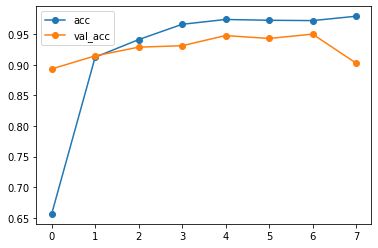

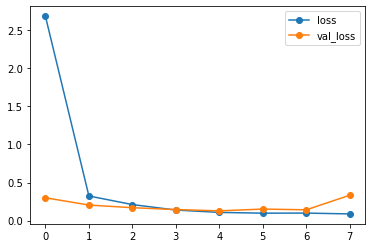

              precision    recall  f1-score   support

           0       0.86      1.00      0.92       127
           1       0.95      0.97      0.96       132
           2       1.00      0.85      0.92       128
           3       0.76      0.95      0.84        40
           4       0.93      0.60      0.72        42

    accuracy                           0.91       469
   macro avg       0.90      0.87      0.87       469
weighted avg       0.92      0.91      0.91       469



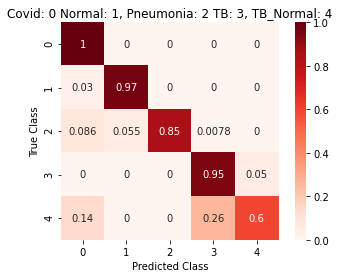

In [ ]:
performance_plot(model_dnet_LR,hist_dnet_LR,X_test,y_test)

In [ ]:
model_dnet_m1 = transfer_model(conv_base_dnet,dense_layers={1:3000,2:1500,3:500,4:256},LeakyReLU=True,Dropout=True)

In [ ]:
hist_dnet_m1 = train_model(model_dnet_m1,X_train,y_train)

Epoch 1/50
60/60 [==============================] - 23s 379ms/step - loss: 4.9489 - acc: 0.3903 - val_loss: 0.4096 - val_acc: 0.8483
Epoch 2/50
60/60 [==============================] - 23s 382ms/step - loss: 0.4192 - acc: 0.8857 - val_loss: 0.1957 - val_acc: 0.8957
Epoch 3/50
60/60 [==============================] - 22s 368ms/step - loss: 0.3498 - acc: 0.9039 - val_loss: 0.2462 - val_acc: 0.9005
Epoch 4/50
60/60 [==============================] - 22s 367ms/step - loss: 0.3162 - acc: 0.9086 - val_loss: 0.1914 - val_acc: 0.9194
Epoch 5/50
60/60 [==============================] - 22s 371ms/step - loss: 0.2500 - acc: 0.9405 - val_loss: 0.1907 - val_acc: 0.9218
Epoch 6/50
60/60 [==============================] - 22s 374ms/step - loss: 0.2504 - acc: 0.9255 - val_loss: 0.1368 - val_acc: 0.9479
Epoch 7/50
60/60 [==============================] - 22s 372ms/step - loss: 0.1668 - acc: 0.9570 - val_loss: 0.1219 - val_acc: 0.9408
Epoch 8/50
60/60 [==============================] - 22s 369ms/step - 

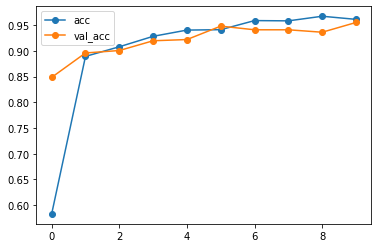

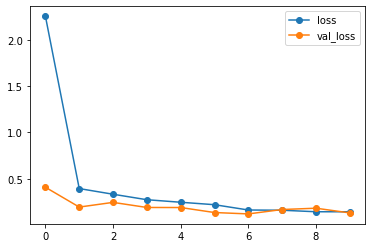

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       127
           1       0.99      0.98      0.98       132
           2       0.96      0.98      0.97       128
           3       0.83      0.95      0.88        40
           4       0.94      0.81      0.87        42

    accuracy                           0.96       469
   macro avg       0.94      0.94      0.94       469
weighted avg       0.96      0.96      0.96       469



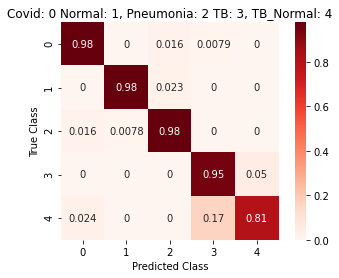

In [ ]:
performance_plot(model_dnet_m1,hist_dnet_m1,X_test,y_test)

### Adding more layers

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(4000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(2000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(1000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(500, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(5, activation='sigmoid',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=0.001),
 metrics=['acc'])

In [ ]:
hist = model.fit(X_train,y_train,epochs=50,batch_size=100,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_acc', min_delta=0, patience=0,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50
38/38 [==============================] - 37s 598ms/step - loss: 103.4437 - acc: 0.3942 - val_loss: 29.4946 - val_acc: 0.8507
Epoch 2/50
38/38 [==============================] - 19s 500ms/step - loss: 25.0961 - acc: 0.9025 - val_loss: 17.2568 - val_acc: 0.9194
Epoch 3/50
38/38 [==============================] - 19s 501ms/step - loss: 16.0977 - acc: 0.9417 - val_loss: 13.5569 - val_acc: 0.9265
Epoch 4/50
38/38 [==============================] - 19s 505ms/step - loss: 13.0768 - acc: 0.9225 - val_loss: 11.7545 - val_acc: 0.9265


In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 8, 8, 1024)        7037504   
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4000)              262148000 
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dense_6 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_7 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,acc,val_loss,val_acc
0,66.604202,0.582609,29.494598,0.850711
1,22.080446,0.897760,17.256807,0.919431
2,15.190350,0.938340,13.556911,0.926540
3,12.640895,0.926219,11.754544,0.926540


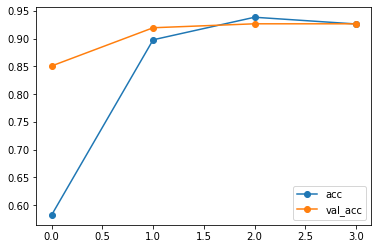

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

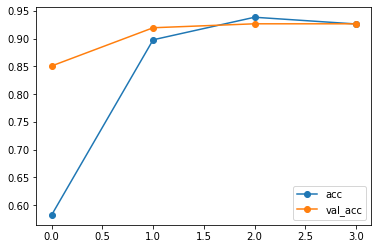

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

In [ ]:
hist = model.fit(X_train,y_train,epochs=20,batch_size=100,validation_data=(X_val,y_val))

Epoch 1/20
38/38 [==============================] - 19s 502ms/step - loss: 11.0884 - acc: 0.9457 - val_loss: 10.5482 - val_acc: 0.9242
Epoch 2/20
38/38 [==============================] - 19s 504ms/step - loss: 10.1213 - acc: 0.9294 - val_loss: 9.7822 - val_acc: 0.9052
Epoch 3/20
38/38 [==============================] - 19s 510ms/step - loss: 9.2623 - acc: 0.9460 - val_loss: 8.8264 - val_acc: 0.9313
Epoch 4/20
38/38 [==============================] - 20s 514ms/step - loss: 8.4510 - acc: 0.9528 - val_loss: 8.1810 - val_acc: 0.9313
Epoch 5/20
38/38 [==============================] - 20s 519ms/step - loss: 7.9680 - acc: 0.9320 - val_loss: 7.7181 - val_acc: 0.9147
Epoch 6/20
38/38 [==============================] - 20s 521ms/step - loss: 7.3637 - acc: 0.9436 - val_loss: 7.2821 - val_acc: 0.9076
Epoch 7/20
38/38 [==============================] - 20s 524ms/step - loss: 6.9600 - acc: 0.9420 - val_loss: 6.9413 - val_acc: 0.8697
Epoch 8/20
38/38 [==============================] - 20s 524ms/step

In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,acc,val_loss,val_acc
0,11.088393,0.945718,10.548152,0.924171
1,10.121272,0.929381,9.782166,0.905213
2,9.262299,0.945982,8.826405,0.931280
3,8.450999,0.952833,8.180978,0.931280
4,7.967988,0.932016,7.718101,0.914692
5,7.363689,0.943610,7.282104,0.907583
6,6.959972,0.942029,6.941318,0.869668
7,6.498155,0.945718,6.236667,0.945498
8,5.994732,0.957839,5.841039,0.926540
9,5.690088,0.943874,5.745005,0.900474


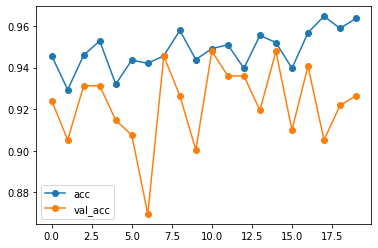

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

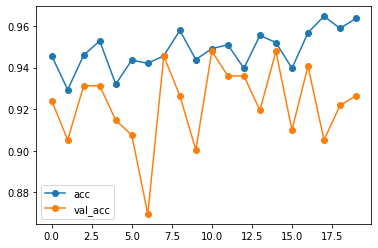

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

## Decreasing Batch Size

In [ ]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(256, 256, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(4000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(2000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(1000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(500, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=0.001),
 metrics=['acc'])

In [ ]:
hist = model.fit(X_train,y_train,epochs=50,batch_size=32,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_acc', min_delta=0, patience=0,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50
119/119 [==============================] - 32s 249ms/step - loss: 41.0117 - acc: 0.5237 - val_loss: 8.1998 - val_acc: 0.8555
Epoch 2/50
119/119 [==============================] - 27s 229ms/step - loss: 7.2665 - acc: 0.8450 - val_loss: 5.1514 - val_acc: 0.8460


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 4000)              131076000 
_________________________________________________________________
dense_11 (Dense)             (None, 2000)              8002000   
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              2001000   
_________________________________________________________________
dense_13 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_14 (Dense)             (None, 256)              

In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,acc,val_loss,val_acc
0,21.025898,0.691700,8.199755,0.855450
1,6.559059,0.822661,5.151412,0.845972


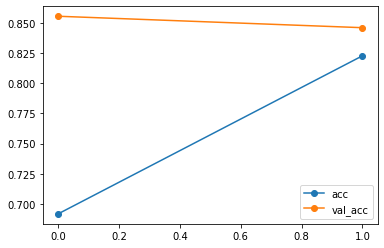

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

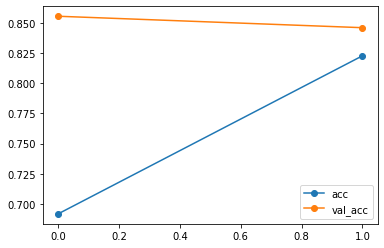

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

### Increasing

In [ ]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(256, 256, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(4000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(2000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(1000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(500, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=0.001),
 metrics=['acc'])

In [ ]:
hist = model.fit(X_train,y_train,epochs=50,batch_size=200,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_acc', min_delta=0, patience=0,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50
19/19 [==============================] - 44s 2s/step - loss: 83.6736 - acc: 0.2804 - val_loss: 28.7297 - val_acc: 0.7085
Epoch 2/50
19/19 [==============================] - 23s 1s/step - loss: 24.2219 - acc: 0.6516 - val_loss: 14.9903 - val_acc: 0.8507
Epoch 3/50
19/19 [==============================] - 24s 1s/step - loss: 13.8857 - acc: 0.8255 - val_loss: 11.1388 - val_acc: 0.8555
Epoch 4/50
19/19 [==============================] - 24s 1s/step - loss: 10.6733 - acc: 0.8409 - val_loss: 9.2166 - val_acc: 0.8815
Epoch 5/50
19/19 [==============================] - 23s 1s/step - loss: 8.9114 - acc: 0.8984 - val_loss: 8.0778 - val_acc: 0.8697


In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,acc,val_loss,val_acc
0,58.287266,0.319895,28.729708,0.708531
1,20.814058,0.678524,14.990283,0.850711
2,13.000116,0.814756,11.138818,0.855450
3,10.217660,0.852964,9.216595,0.881517
4,8.681081,0.877997,8.077827,0.869668


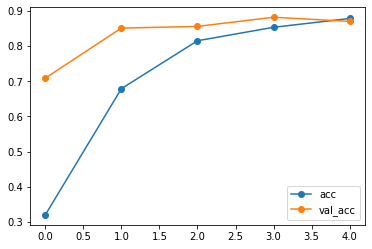

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

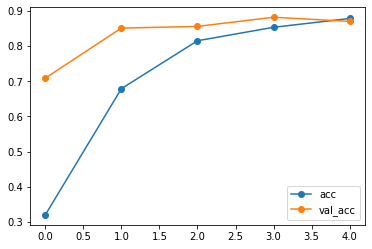

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

In [ ]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(256, 256, 3))
conv_base.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(4000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(layers.Dense(2000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(1000, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# model.add(layers.Dense(500, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',

 optimizer=optimizers.Adam(lr=0.001),
 metrics=['acc'])

In [ ]:
hist = model.fit(X_train,y_train,epochs=50,batch_size=500,validation_data=(X_val,y_val),
                callbacks=EarlyStopping(monitor='val_acc', min_delta=0, patience=0,mode='auto',
                                        restore_best_weights=False))

Epoch 1/50


ResourceExhaustedError: ignored

In [ ]:
hist_df = pd.DataFrame(hist.history)
hist_df

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

In [ ]:
hist_df[['acc','val_acc']].plot(marker='o')

## Trying from the drive

In [ ]:
df_img_drive = pd.read_csv('/content/gdrive/MyDrive/Data Science/Capstone Data/img_labels_colab.csv',header=None)
df_img_drive.columns = ['file','category']
df_img_drive

,file,category
0,/content/gdrive/MyDrive/Data Science/Capstone ...,0
1,/content/gdrive/MyDrive/Data Science/Capstone ...,0
2,/content/gdrive/MyDrive/Data Science/Capstone ...,0
3,/content/gdrive/MyDrive/Data Science/Capstone ...,0
4,/content/gdrive/MyDrive/Data Science/Capstone ...,0
...,...,...
4682,/content/gdrive/MyDrive/Data Science/Capstone ...,4
4683,/content/gdrive/MyDrive/Data Science/Capstone ...,4
4684,/content/gdrive/MyDrive/Data Science/Capstone ...,4
4685,/content/gdrive/MyDrive/Data Science/Capstone ...,4


In [ ]:
cat_map = {0: 'Covid', 1: 'Normal', 2:'TB', 3:'TB_Normal',4:'Pneumonia'}
df_img_drive['Category_name']=df_img_drive['category'].map(cat_map)
df_img_drive

,file,category,Category_name
0,/content/gdrive/MyDrive/Data Science/Capstone ...,0,Covid
1,/content/gdrive/MyDrive/Data Science/Capstone ...,0,Covid
2,/content/gdrive/MyDrive/Data Science/Capstone ...,0,Covid
3,/content/gdrive/MyDrive/Data Science/Capstone ...,0,Covid
4,/content/gdrive/MyDrive/Data Science/Capstone ...,0,Covid
...,...,...,...
4682,/content/gdrive/MyDrive/Data Science/Capstone ...,4,Pneumonia
4683,/content/gdrive/MyDrive/Data Science/Capstone ...,4,Pneumonia
4684,/content/gdrive/MyDrive/Data Science/Capstone ...,4,Pneumonia
4685,/content/gdrive/MyDrive/Data Science/Capstone ...,4,Pneumonia


In [ ]:
image_set_drive = datagen.flow_from_dataframe(dataframe=df_img_drive,
                                        directory=None,
                                        x_col = 'file',
                                        y_col = 'Category_name',
                                        batch_size=4687,
                                        )

Found 4687 validated image filenames belonging to 5 classes.


In [ ]:
X,y = next(image_set_drive)

UnidentifiedImageError: ignored